# Data 620 - Project 3
Baron Curtin, Heather Geiger, Mikhail Groysman, Betsy Rosalen 

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender
classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are
satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what
you'd expect? 

In [197]:
# library imports
import random
import re
import string
import nltk
from collections import Counter
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
from nltk import DecisionTreeClassifier
from nltk import classify
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Data Loading/Preparation
In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the
list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from 
which we should be able to create numerous features from.

In [198]:
# read in names from the files
# label each name with corresponding gender
# names to be lowercase for easy recognition 
download('names')
males = [(name.lower().strip(), 'male') for name in names.words('male.txt')]
females = [(name.lower().strip(), 'female') for name in names.words('female.txt')]

#Remove unisex names from each list.
#Did not run this previously, but I think it is reasonable to do so.
#Otherwise accuracy unfairly penalized if a unisex name is listed as one gender in training and another in test.
#Will be marked as wrong even if the model is otherwise perfect.

unisex = list(set(males) & set(females))
[males.remove(name) for name in unisex]
[females.remove(name) for name in unisex]

# combine lists of names
all_names = males + females

# randomize the list
random.seed(5)
random.shuffle(all_names)

[nltk_data] Downloading package names to
[nltk_data]     /Users/betsyrosalen/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

[]

[]

## Feature Creation
Features are the most important part of what goes into a machine learning model. For that reason, it is critically important
to try to come up with features that make the most sense in identifying gender differences in names. To make creation and analysis easier,
we will put our data in a Pandas dataframe.

In [199]:
# create dataframe
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.head()

,name,gender
0,dasi,female
1,marius,male
2,marlene,female
3,margaret,female
4,nickie,male


In [200]:
# instatiate syllable tokenize
SSP = SyllableTokenizer()

# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(SSP.tokenize(x)))

# preview data
data.head()

,name,gender,length,first_letter,last_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
0,dasi,female,4,d,i,True,False,ai,ds,2,2,"[(d, a), (a, s), (s, i)]","[(d, a, s), (a, s, i)]",2
1,marius,male,6,m,s,False,False,aiu,mrs,3,3,"[(m, a), (a, r), (r, i), (i, u), (u, s)]","[(m, a, r), (a, r, i), (r, i, u), (i, u, s)]",2
2,marlene,female,7,m,e,True,False,aee,mrln,3,4,"[(m, a), (a, r), (r, l), (l, e), (e, n), (n, e)]","[(m, a, r), (a, r, l), (r, l, e), (l, e, n), (...",3
3,margaret,female,8,m,t,False,False,aae,mrgrt,3,5,"[(m, a), (a, r), (r, g), (g, a), (a, r), (r, e...","[(m, a, r), (a, r, g), (r, g, a), (g, a, r), (...",3
4,nickie,male,6,n,e,True,False,iie,nck,3,3,"[(n, i), (i, c), (c, k), (k, i), (i, e)]","[(n, i, c), (i, c, k), (c, k, i), (k, i, e)]",2


In [201]:
# lets analyze our bigrams and trigrams columns to get the most common ngrams by gender
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(d, a), (a, s), (s, i), (m, a), (a, r), (r, l...","[(d, a, s), (a, s, i), (m, a, r), (a, r, l), (...","{('d', 'a'): 256, ('a', 's'): 72, ('s', 'i'): ...","{('d', 'a', 's'): 4, ('a', 's', 'i'): 16, ('m'..."
male,"[(m, a), (a, r), (r, i), (i, u), (u, s), (n, i...","[(m, a, r), (a, r, i), (r, i, u), (i, u, s), (...","{('m', 'a'): 147, ('a', 'r'): 345, ('r', 'i'):...","{('m', 'a', 'r'): 49, ('a', 'r', 'i'): 24, ('r..."


Using the counter class and the bigrams and trigrams, we can eliminate the need for the most common bigram/trigram and instead
just use the list of bigrams and trigrams as features. The most common bigram was only in ~13% of the female names and ~12%
of the male names.

## Data Exploration
Lets get a better feel for how our data is composed. In this exploration step, we will confirm whether any of the features
we created will become good predictors of gender. Exploration will occur both visually as well as computationally.

In [202]:
# use our created variables to generate some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.158750,0.726250,0.174167,2.679792,3.478958,2.479375
male,5.927207,0.235315,0.155676,2.199640,3.727568,2.044685


In [203]:
# separate features from label
X = data.drop(columns=['name', 'gender'])
y = data['gender']

Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel.
These appear to be good predictors. We need to visual confirm what we see numerically

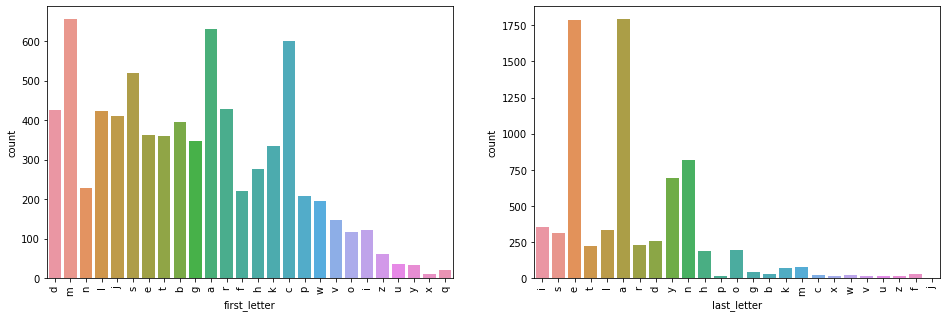

In [204]:
# categorical/numerical columns
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot)
    # rotate labels for easy viewing
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
plt.show();

The distributions above don't tell us much. We need to condition on gender.

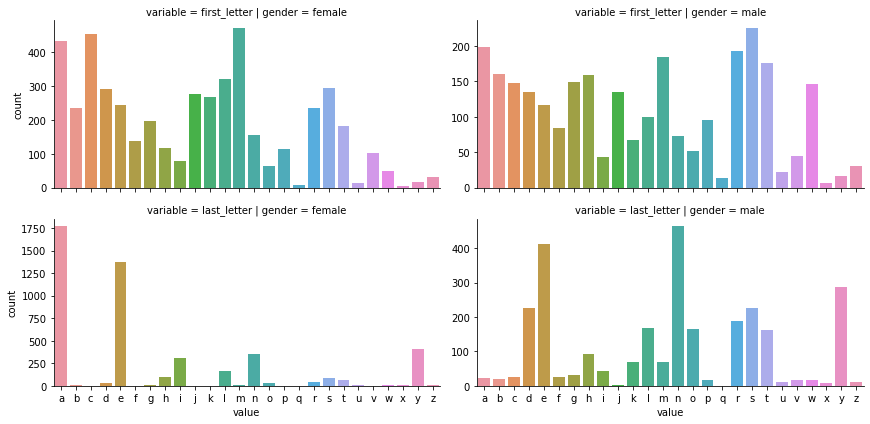

In [205]:
data_melted = pd.melt(data[['gender','first_letter','last_letter']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            order = list(string.ascii_lowercase), sharey = False, height=3, aspect=2)

plt.show();

It would appear that both the first and the last letter could be pretty good predictors for gender.

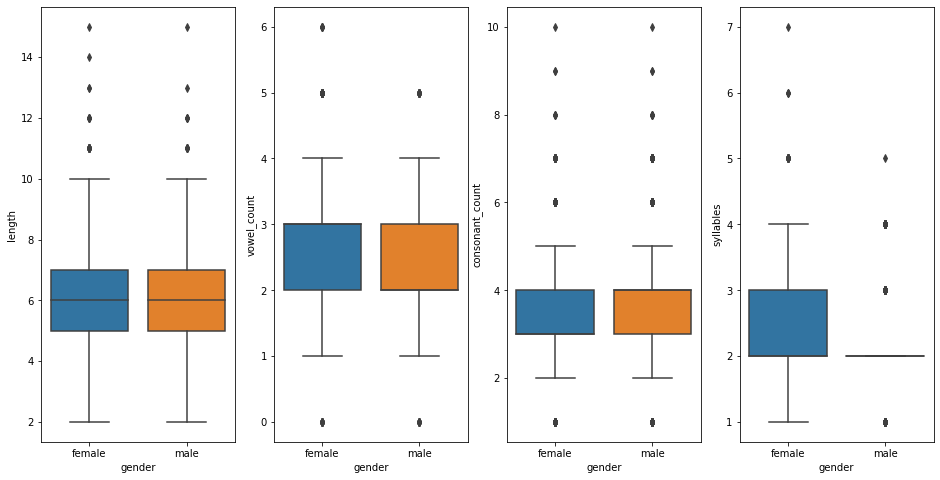

In [206]:
# numerical columns to gender exploration
fig, ax = plt.subplots(1, 4, figsize=(16, 8))

for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot)
    
plt.show();

From the boxplots above, it seems we can safely rule out vowel count, consonant count, and length as strong predictors of gender.  Syllables, however, seems like it may be a good predictor.

However, we decided to try a conditional count plot for each of these variables like we did for first and last letter in case boxplots are not the best way to look at these variables, as they are integers with a fairly narrow range.

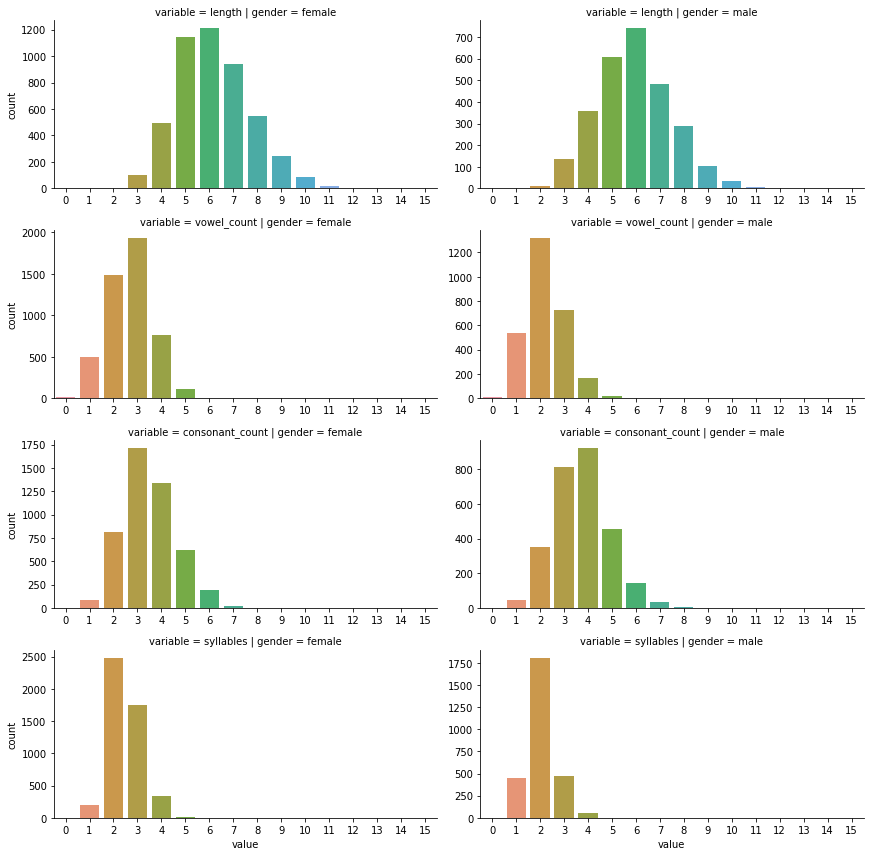

In [207]:
data_melted = pd.melt(data[['gender','length','vowel_count','consonant_count','syllables']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            sharey = False, sharex=False, height=3, aspect=2)

plt.show();

Looks like the conclusion still mostly holds that we can exclude length, vowel count, and consonant count.

## Decision Tree

### Feature Generation Function

This function will be applied to our lists of names to create the features that we identified as potential predictors above in our initial model "kitchen sink" approach.  As we refine the model we will also refine this function to include only the features that seem most relevant to our classifier.  Vowel count, consonant count, and length have already been removed since they were found above to have no predictive value.  

In [208]:
# feature generator
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

### Data Preparation
We need to split the lists into training, test, and validation sets and apply our feature generation function.

In [209]:
# create each set of data
dev_set_names = all_names[:1000]
test_names = all_names[1000:]

# split the development set into initial training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features(name), gender) for name, gender in test_names]
train_set = [(gender_features(name), gender) for name, gender in train_names]
devtest_set = [(gender_features(name), gender) for name, gender in devtest_names]

/Users/betsyrosalen/anaconda3/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


### First decision tree model - 'Kitchen sink' approach

We start by fitting a decision tree model to our full list of potential features.  The "kitchen sink" approach described in the textbook will give us a baseline model which we will then atempt to refine for greater accuracy.

In [210]:
classifier = DecisionTreeClassifier.train(test_set)

In [211]:
print('Accuracy: %4.2f' % classify.accuracy(classifier, devtest_set))

Accuracy: 0.62


Our accuracy was not too bad for a first attempt, but we wanted to do better so took a look at the errors to see if there were any obvious patterns.

In [212]:
def error_list(devtest_names, feature_extractor):
    errors = []
    for (name, tag) in devtest_names:
        guess = classifier.classify(feature_extractor(name))
        if guess != tag:
            errors.append((tag, guess, name))
    for (tag, guess, features) in sorted(errors):
        print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, features))
    return errors

errors = error_list(devtest_names, gender_features)

correct=male     guess=female   name=abby                          
correct=male     guess=female   name=alessandro                    
correct=male     guess=female   name=andy                          
correct=male     guess=female   name=anson                         
correct=male     guess=female   name=armand                        
correct=male     guess=female   name=arnie                         
correct=male     guess=female   name=arnoldo                       
correct=male     guess=female   name=ashby                         
correct=male     guess=female   name=aube                          
correct=male     guess=female   name=augie                         
correct=male     guess=female   name=avi                           
correct=male     guess=female   name=barnett                       
correct=male     guess=female   name=bartholomeo                   
correct=male     guess=female   name=bartie                        
correct=male     guess=female   name=bartolomeo 

Looking at the errors didn't reveal any obvious patterns but the textbook indicated that the last two letters were a good indicator in addition to just the last letter.  So we added that to our features and removed the bigrams and trigrams since no two lists will be the same and individual bigrams or trigrams are unlikely to be a good indicator since our earlier analysis indicated that there were no particularly common bigrams or trigrams.

### Refine decision tree features - Second model

We refined our feature extractor function by removing bigrams and trigrams and added a new feature, last_two, to indicate the last two letters of the name.

In [213]:
# feature generator 2
def gender_features2(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last two letters
    last_two = name[-2:]
    
    # vowel/consonants + counts
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_two': last_two,
        'vowels': vowels,
        'consonants': consonants,
        'syllables': syllables
    }

According to the textbook, "Each time the error analysis procedure is repeated, we should select a different dev-test/training split, to ensure that the classifier does not start to reflect idiosyncrasies in the dev-test set." So we reshuffled our training data to get a new split for the train and devtest sets.

In [214]:
# shuffle the dev_set_names to get a new split
random.seed(25)
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features2(name), gender) for name, gender in test_names]
train_set = [(gender_features2(name), gender) for name, gender in train_names]
devtest_set = [(gender_features2(name), gender) for name, gender in devtest_names]

We refit the model using our refined list of potential features.  

In [215]:
classifier2 = DecisionTreeClassifier.train(train_set)

In [216]:
'Accuracy: %4.2f' % classify.accuracy(classifier2, devtest_set)

'Accuracy: 0.55'

Unfortunately our accuracy score went down!  We examined the errors again to see if anything new became evident.

In [217]:
errors = error_list(devtest_names, gender_features2)

correct=male     guess=female   name=abby                          
correct=male     guess=female   name=aleck                         
correct=male     guess=female   name=andres                        
correct=male     guess=female   name=andy                          
correct=male     guess=female   name=anson                         
correct=male     guess=female   name=aristotle                     
correct=male     guess=female   name=armand                        
correct=male     guess=female   name=arnoldo                       
correct=male     guess=female   name=ashby                         
correct=male     guess=female   name=aubert                        
correct=male     guess=female   name=augie                         
correct=male     guess=female   name=avi                           
correct=male     guess=female   name=barnaby                       
correct=male     guess=female   name=barnett                       
correct=male     guess=female   name=bartholomeo

There are a lot of female names that end in vowels misclassified as male names in our new error list.  Having both the last letter and the last two letters as features may not be working to our benefit. We also printed the pseudocode to see what features were most relevant to our tree structure.

In [218]:
print(classifier2.pseudocode(depth=4))

if consonants == '-jn': return 'female'
if consonants == '-mnr': return 'female'
if consonants == 'b': return 'male'
if consonants == 'bc': return 'male'
if consonants == 'bckr': return 'female'
if consonants == 'bcky': return 'female'
if consonants == 'bclr': return 'female'
if consonants == 'bcy': return 'female'
if consonants == 'bdgr': return 'female'
if consonants == 'bdgrt': return 'female'
if consonants == 'bdhlnr': return 'female'
if consonants == 'bdlrt': return 'male'
if consonants == 'bdnrt': return 'male'
if consonants == 'bdnt': return 'female'
if consonants == 'bdr': return 'female'
if consonants == 'bg': return 'female'
if consonants == 'bgl': return 'female'
if consonants == 'bglr': return 'female'
if consonants == 'bglrt': return 'male'
if consonants == 'bgrs': return 'male'
if consonants == 'bhlmtw': return 'male'
if consonants == 'bhltz': return 'female'
if consonants == 'bhrt': return 'male'
if consonants == 'bj': return 'male'
if consonants == 'bl': return 'female'

Looking at the the pseudocode, we could see that the consonants feature was the most influential feature in our dataset, but since there are so few names that will have matching lists of consonants this would be overfitting and probably not result in a good accuracy score when applied to new data.  

### Refine decision tree features - Third model

From our analysis above we decided to remove last_letter and consonants from our features.  Through iterative trial and error we also decided to remove vowels and syllables.  Our final feature extractor includes only the first_letter, vowel_first_letter, vowel_last_letter, and last_two features.

In [219]:
# feature generator 3
def gender_features3(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last two letters
    last_two = name[-2:]
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_two': last_two
    }

We needed to reshuffle and re-split the data again.

In [220]:
# shuffle the dev_set_names to get a new split
random.seed(50)
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features3(name), gender) for name, gender in test_names]
train_set = [(gender_features3(name), gender) for name, gender in train_names]
devtest_set = [(gender_features3(name), gender) for name, gender in devtest_names]

We refit the model again using our further refined list of potential features.  

In [221]:
classifier3 = DecisionTreeClassifier.train(train_set)

In [222]:
'Accuracy: %4.2f' % classify.accuracy(classifier3, devtest_set)

'Accuracy: 0.73'

Our final model resulted in a much improved accuracy in the range of 0.69 to 0.73 depending on the random seeed selected.  

In [223]:
errors = error_list(devtest_names, gender_features3)

correct=male     guess=female   name=adger                         
correct=male     guess=female   name=aleck                         
correct=male     guess=female   name=alessandro                    
correct=male     guess=female   name=alexei                        
correct=male     guess=female   name=andy                          
correct=male     guess=female   name=anson                         
correct=male     guess=female   name=antonio                       
correct=male     guess=female   name=aristotle                     
correct=male     guess=female   name=arnoldo                       
correct=male     guess=female   name=aubert                        
correct=male     guess=female   name=augie                         
correct=male     guess=female   name=barnaby                       
correct=male     guess=female   name=barnett                       
correct=male     guess=female   name=bartel                        
correct=male     guess=female   name=bartie     

Error analysis shows another potential feature.  There are many female names ending in elle.  Creating a boolean for this may improve our results.  

In [224]:
print(classifier3.pseudocode(depth=4))

if last_two == 'ae': return 'female'
if last_two == 'ah': return 'female'
if last_two == 'aj': return 'male'
if last_two == 'al': 
  if first_letter == 'h': return 'male'
  if first_letter == 'i': return 'female'
  if first_letter == 'k': return 'female'
  if first_letter == 'p': return 'male'
  if first_letter == 'v': return 'female'
if last_two == 'am': 
  if first_letter == 'h': return 'male'
  if first_letter == 'p': return 'male'
  if first_letter == 's': return 'female'
  if first_letter == 'w': return 'male'
if last_two == 'an': 
  if first_letter == 'c': return 'male'
  if first_letter == 'd': return 'female'
  if first_letter == 'h': return 'male'
  if first_letter == 'j': return 'male'
  if first_letter == 'l': return 'female'
  if first_letter == 'm': return 'female'
  if first_letter == 's': return 'male'
if last_two == 'ar': return 'male'
if last_two == 'as': return 'male'
if last_two == 'at': 
  if first_letter == 'b': return 'male'
  if first_letter == 'c': return 'femal

Looking at the pseudocode, we see that we still never go past two levels of nested if statements, but now the last_two is the most relevant feature with the first letter as the most frequent feature in the second depth level of the tree.  

### Refine decision tree features - Fourth model

We tried changing last_two to last_three.  First we revised our feature generator.

In [225]:
# feature generator
def gender_features4(name):
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # last three letters
    last_three = name[-3:]
       
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'vowel_last_letter': vowel_last_letter,
        'last_three': last_three
    }

Then we reshuffled and re-split our development set.

In [226]:
# shuffle the dev_set_names to get a new split
random.seed(75)
random.shuffle(dev_set_names)

# split the development set into training and test sets
train_names = dev_set_names[:500]
devtest_names = dev_set_names[500:]

# apply feature generation function
test_set = [(gender_features4(name), gender) for name, gender in test_names]
train_set = [(gender_features4(name), gender) for name, gender in train_names]
devtest_set = [(gender_features4(name), gender) for name, gender in devtest_names]

Then we refit our model to the new datasets.

In [227]:
classifier4 = DecisionTreeClassifier.train(train_set)

In [228]:
'Accuracy: %4.2f' % classify.accuracy(classifier4, devtest_set)

'Accuracy: 0.65'

Changing the last_two feature to last_three reduced the accuracy of our model significantly, so our prevvious model still seems to be our best.    

In [229]:
print(classifier4.pseudocode(depth=4))

if last_three == 'aby': return 'male'
if last_three == 'aid': return 'male'
if last_three == 'ail': return 'female'
if last_three == 'ain': return 'male'
if last_three == 'aja': return 'female'
if last_three == 'all': return 'male'
if last_three == 'ami': return 'female'
if last_three == 'ana': return 'female'
if last_three == 'and': 
  if first_letter == 'a': return 'male'
  if first_letter == 'b': return 'male'
  if first_letter == 'f': return 'female'
  if first_letter == 'r': return 'male'
if last_three == 'ane': return 'female'
if last_three == 'ang': return 'male'
if last_three == 'ank': return 'female'
if last_three == 'ann': 
  if first_letter == 'h': return 'male'
  if first_letter == 'j': return 'female'
if last_three == 'ard': return 'male'
if last_three == 'are': return 'male'
if last_three == 'aro': return 'female'
if last_three == 'arv': return 'male'
if last_three == 'ary': return 'male'
if last_three == 'ata': return 'female'
if last_three == 'aun': return 'female'
if l

Looking at the pseudocode, we see that we still never go past two levels of nested if statements, but now the last_three is the most relevant feature with the tree often never going beyond that depth indicating again that we are overfitting.  

### Classify test data 

In [230]:
'Accuracy: %4.2f' % classify.accuracy(classifier, test_set)

'Accuracy: 0.63'

In [231]:
'Accuracy: %4.2f' % classify.accuracy(classifier2, test_set)

'Accuracy: 0.37'

In [232]:
'Accuracy: %4.2f' % classify.accuracy(classifier3, test_set)

'Accuracy: 0.37'

In [233]:
'Accuracy: %4.2f' % classify.accuracy(classifier4, test_set)

'Accuracy: 0.67'

Surprisingly the last model which uses the last three letters of the name as the main and often sole predictor is the most accurate on the test data.  The third model that we thought was our best is actually the worst performer.  

Looking back at the pseudocode it became clear that the third model relied too heavily on the first letter at depth level 2 and since the data didn't have enough examples, there were many letters missing from the tree leaves.  So there are many dead ends in our model and when faced with new data the model wouldn't know how to classify them.  

By comparison the fourth model relied almost exclusively on the last three letters, and apparently there are patterns in the ending trigram that are repeated often enough that it is a very good predictor.

## Maximum Entropy 

### Feature generation

#### Feature generation function

This function will be applied to our lists of names to create the features that we identified as potential predictors above in our initial model "kitchen sink" approach. As we refine the model we will also refine this function to include only the features that seem most relevant to our classifier. Vowel count, consonant count, and length have already been removed since they were found above to have no predictive value.

In [234]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

#### Training/test split and apply feature generation function.

In [235]:
# create each set of data
final_test = all_names[:500]
num_remaining = len(all_names) - 500
training_and_dev_test = all_names[-num_remaining:]

#Separate the training and dev test data.
#We will call these "dev_test1" and "training1".

dev_test1 = training_and_dev_test[:500]
training1 = training_and_dev_test[500:]

#Shuffle to create four additional training vs. dev-test splits.

random.shuffle(training_and_dev_test)
dev_test2 = training_and_dev_test[:500]
training2 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test3 = training_and_dev_test[:500]
training3 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test4 = training_and_dev_test[:500]
training4 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test5 = training_and_dev_test[:500]
training5 = training_and_dev_test[500:]

# apply feature generation function
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

### Apply model

#### Initial model

Now that we have all our features and have run training/test split, we are ready to apply the model.

In this notebook, we will be using the maximum entropy model.

Run using a few different training/test splits to get a range of accuracy values.

In [236]:
classifier1v1 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v1 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v1 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v1 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v1 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


Check the accuracy of this model on our dev test data.

In [237]:
nltk.classify.accuracy(classifier1v1, dev_test_features1)
nltk.classify.accuracy(classifier2v1, dev_test_features2)
nltk.classify.accuracy(classifier3v1, dev_test_features3)
nltk.classify.accuracy(classifier4v1, dev_test_features4)
nltk.classify.accuracy(classifier5v1, dev_test_features5)

0.798

0.77

0.778

0.778

0.808

Accuracy ranges from ~77-81%.

This is a good start, but we can probably improve the accuracy even further. Let's try and do that in the next section.

### Refining the model

One way to possibly improve accuracy is to either add new features, or remove existing features that are not actually predictive.

A good place to start in deciding which features to add or remove is by examining the errors, similar to what was done in the textbook.

In [238]:
errors = []

for (name,tag) in dev_test1:
    guess = classifier1v1.classify(gender_features(name))
    if guess != tag:
        errors.append((tag,guess,name))

In [239]:
for (tag,guess,name) in sorted(errors):
    print('correct={:<8} guess={:<8s} name={:30}'.format(tag,guess,name))

correct=female   guess=male     name=alisun                        
correct=female   guess=male     name=allis                         
correct=female   guess=male     name=ardeen                        
correct=female   guess=male     name=audrey                        
correct=female   guess=male     name=becky                         
correct=female   guess=male     name=bel                           
correct=female   guess=male     name=brit                          
correct=female   guess=male     name=brynn                         
correct=female   guess=male     name=cass                          
correct=female   guess=male     name=charo                         
correct=female   guess=male     name=cyb                           
correct=female   guess=male     name=darleen                       
correct=female   guess=male     name=darryl                        
correct=female   guess=male     name=deb                           
correct=female   guess=male     name=dionis     

Print feature details for names actually female, incorrectly guess as male, then vice versa.

In [240]:
actually_female_guessed_incorrectly = []
actually_male_guessed_incorrectly = []

for (tag,guess,name) in sorted(errors):
    if tag == "female":
        actually_female_guessed_incorrectly.append(name)
    if tag == "male":
        actually_male_guessed_incorrectly.append(name)

In [241]:
print("First letter count errors, actually female then actually male:")
Counter([name[0] for name in actually_female_guessed_incorrectly])
Counter([name[0] for name in actually_male_guessed_incorrectly])
print("First letter vowel count errors:")
Counter([name[0] in 'aeiou' for name in actually_female_guessed_incorrectly])
Counter([name[0] in 'aeiou' for name in actually_male_guessed_incorrectly])
print("Last letter count errors:")
Counter([name[-1] for name in actually_female_guessed_incorrectly])
Counter([name[-1] for name in actually_male_guessed_incorrectly])
print("Last letter vowel count errors:")
Counter([name[-1] in 'aeiou' for name in actually_female_guessed_incorrectly])
Counter([name[-1] in 'aeiou' for name in actually_male_guessed_incorrectly])
print("List of vowels count errors:")
Counter(["".join(sorted(list(set(re.sub(r'[^aeiou]', '', name))))) for name in actually_female_guessed_incorrectly])
Counter(["".join(sorted(list(set(re.sub(r'[^aeiou]', '', name))))) for name in actually_male_guessed_incorrectly])

First letter count errors, actually female then actually male:


Counter({'a': 4,
         'b': 4,
         'c': 3,
         'd': 5,
         'e': 2,
         'f': 1,
         'g': 4,
         'h': 4,
         'i': 1,
         'j': 1,
         'n': 2,
         'o': 1,
         'p': 1,
         'r': 3,
         't': 1,
         'w': 1})

Counter({'a': 9,
         'b': 1,
         'c': 8,
         'd': 1,
         'e': 2,
         'f': 1,
         'g': 3,
         'h': 3,
         'i': 1,
         'j': 4,
         'k': 2,
         'l': 5,
         'm': 4,
         'n': 2,
         'p': 4,
         'r': 3,
         's': 3,
         't': 3,
         'v': 1,
         'w': 2,
         'y': 1})

First letter vowel count errors:


Counter({True: 8, False: 30})

Counter({True: 12, False: 51})

Last letter count errors:


Counter({'n': 9,
         's': 3,
         'y': 8,
         'l': 2,
         't': 3,
         'o': 2,
         'b': 2,
         'w': 1,
         'm': 1,
         'e': 1,
         'k': 1,
         'r': 3,
         'z': 1,
         'h': 1})

Counter({'y': 10,
         'o': 2,
         'n': 8,
         'e': 27,
         'i': 4,
         'l': 7,
         'u': 1,
         'h': 3,
         's': 1})

Last letter vowel count errors:


Counter({False: 35, True: 3})

Counter({False: 29, True: 34})

List of vowels count errors:


Counter({'aiu': 1,
         'ai': 1,
         'ae': 3,
         'aeu': 1,
         'e': 14,
         'i': 1,
         '': 3,
         'a': 3,
         'ao': 2,
         'io': 2,
         'aio': 3,
         'ei': 1,
         'o': 2,
         'u': 1})

Counter({'a': 7,
         'aeo': 3,
         'ao': 2,
         'aei': 8,
         'aeu': 2,
         'aeiu': 2,
         'ai': 5,
         'ae': 2,
         'eio': 5,
         'eou': 1,
         '': 1,
         'eiu': 2,
         'ei': 8,
         'e': 9,
         'aiu': 2,
         'aio': 1,
         'i': 2,
         'iu': 1})

Looks like we find that names that are actually male that were guessed incorrectly often end in "e".

They are seem likely to contain an "a" and or "e".

Check incidence of an a and/or e in the name in males vs. females in the training data.

In [242]:
def vowels(name):
    return "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))

Counter([list(name).count('a') >= 1 for name,tag in training1 if tag == "female"])
Counter([list(name).count('a') >= 1 for name,tag in training1 if tag == "male"])

Counter([list(name).count('e') >= 1 for name,tag in training1 if tag == "female"])
Counter([list(name).count('e') >= 1 for name,tag in training1 if tag == "male"])

Counter({False: 1427, True: 2951})

Counter({False: 1272, True: 1294})

Counter({False: 1701, True: 2677})

Counter({False: 1167, True: 1399})

Females are much more likely to have an a and/or an e in their name than males.

So it is not surprising that males with these vowels in their name are getting guessed as females.

And no clear way to correct without decreasing accuracy for names that have a/e and are female, or that do not have it and are male.

Let's try adding a "suffix2" feature (last two letters) and see if that improves accuracy, like they did in the textbook.

In [243]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    last_two_letters = name[-2:]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'last_two_letters': last_two_letters,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [244]:
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

In [245]:
classifier1v2 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v2 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v2 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v2 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v2 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


In [246]:
nltk.classify.accuracy(classifier1v2, dev_test_features1)
nltk.classify.accuracy(classifier2v2, dev_test_features2)
nltk.classify.accuracy(classifier3v2, dev_test_features3)
nltk.classify.accuracy(classifier4v2, dev_test_features4)
nltk.classify.accuracy(classifier5v2, dev_test_features5)

0.808

0.79

0.794

0.792

0.82

In some cases we see an improvement, or worst case accuracy remains about the same.

What if we include the second-to-last letter as a separate variable instead?

In [255]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    next_to_last_letter = name[-2]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'next_to_last_letter': next_to_last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [256]:
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

In [257]:
classifier1v3 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v3 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v3 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v3 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v3 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


In [258]:
nltk.classify.accuracy(classifier1v3, dev_test_features1)
nltk.classify.accuracy(classifier2v3, dev_test_features2)
nltk.classify.accuracy(classifier3v3, dev_test_features3)
nltk.classify.accuracy(classifier4v3, dev_test_features4)
nltk.classify.accuracy(classifier5v3, dev_test_features5)

0.804

0.78

0.786

0.794

0.808

Similar to what we saw with the two-letter suffix, we sometimes see improvement in accuracy after adding the next-to-last letter feature, sometimes not.

### Final model evaluation

#### Accuracy on final test data

We are now ready to check model accuracy on the final test data.

Let's just use the model including all of our initially chosen variables, without the two-letter suffix or next-to-last letter features.

Improvement in accuracy was not enough to justify making the model more complicated than it needs to be.

In [259]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

final_test_features = [(gender_features(name), gender) for name, gender in final_test]

In [260]:
nltk.classify.accuracy(classifier1v1, final_test_features)
nltk.classify.accuracy(classifier2v1, final_test_features)
nltk.classify.accuracy(classifier3v1, final_test_features)
nltk.classify.accuracy(classifier4v1, final_test_features)
nltk.classify.accuracy(classifier5v1, final_test_features)

0.8039647577092511

0.801762114537445

0.8105726872246696

0.8105726872246696

0.8171806167400881

Accuracy ranges from ~80-82% on the final test data using features of first letter, vowel first letter, last letter, vowel last letter, vowels, consonants, bigrams, and trigrams.

## Youtube Link
[Data 620 - Project 3](https://youtu.be/bWYYesVMXbs)